In [1]:
import torch
import os
import numpy as np
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import import_ipynb
import data_preprocessing 
import gibbs_sampler_poise
import kl_divergence_calculator
from torchvision.utils import save_image
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.nn import functional as F  #for the activation function
from torchviz import make_dot
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import torchvision
import umap
import random
import shutil

importing Jupyter notebook from data_preprocessing.ipynb
importing Jupyter notebook from gibbs_sampler_poise.ipynb
importing Jupyter notebook from kl_divergence_calculator.ipynb


In [2]:
# learning parameters
latent_dim1 = 32
latent_dim2 = 16
batch_size = 10
dim_VIDEO   = 19200
dim_WFIELD   = 2* 135* 160
lr = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tx = transforms.ToTensor()
#VIDEO_PATH          = "/hdd/achint_files/musall_behavior/video_dataset.p"
VIDEO_TRAINING_PATH = "/hdd/achint_files/musall_behavior/video_training_data.npy"
VIDEO_TEST_PATH     = "/hdd/achint_files/musall_behavior/video_test_data.npy"

# WFIELD_TRAINING_PATH= "/hdd/achint_files/musall_behavior/wfield_train_data.npy"
# WFIELD_TEST_PATH="/hdd/achint_files/musall_behavior/wfield_test_data.npy"
WFIELD_TRAINING_PATH = "/hdd/achint_files/wfield_data/DOWNSAMPLED_wfield_train_data.npy"
WFIELD_TEST_PATH     = "/hdd/achint_files/wfield_data/DOWNSAMPLED_wfield_test_data.npy"

SUMMARY_WRITER_PATH = "/home/achint/Practice_code/logs"
RECONSTRUCTION_PATH = "/home/achint/Practice_code/Synthetic_dataset/POISE_VIDEO_WFIELD/reconstructions/"
PATH = "/home/achint/Practice_code/Synthetic_dataset/POISE_VIDEO_WFIELD/untitled.txt"

In [3]:
# Remove the logs directory and the reconstruction directory 
if os.path.exists(RECONSTRUCTION_PATH):
    shutil.rmtree(RECONSTRUCTION_PATH)
    os.makedirs(RECONSTRUCTION_PATH)

if os.path.exists(SUMMARY_WRITER_PATH):
    shutil.rmtree(SUMMARY_WRITER_PATH)
    os.makedirs(SUMMARY_WRITER_PATH)

In [3]:
## Importing VIDEO and WFIELD datasets
joint_dataset_train = data_preprocessing.EvilMouDataSet(video_dir=VIDEO_TRAINING_PATH,
                                                        wfield_dir = WFIELD_TRAINING_PATH)
joint_dataset_test  = data_preprocessing.EvilMouDataSet(video_dir=VIDEO_TEST_PATH,
                                                        wfield_dir = WFIELD_TEST_PATH)
joint_dataset_train_loader = DataLoader(
    joint_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
joint_dataset_test_loader = DataLoader(
    joint_dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

In [4]:
# for i,joint_data in enumerate(joint_dataset_train):
#         data1   = joint_data[0]
#         data1   = data1.float()
#         data2   = joint_data[1]
#         data2   = data2.float()
#         data1   = data1.to(device)
#         data2   = data2.to(device)
#         data1   = data1.view(data1.size(0), -1)
#         data2   = data2.view(data2.size(0), -1)
#         data2   = data2.view(-1,2, 135,160) 
#         if i == 5:
#             print(data1.size())
#             print(data2.size())
#         data1    = data1.view(data1.size(0), -1)
#         data2    = data2.view(data2.size(0), -1)


In [5]:
# set2_enc2 = nn.Conv2d(in_channels=latent_dim2, out_channels=latent_dim2, kernel_size=4, stride=2, padding=1)
# x=torch.zeros(10,16,67,80)
# set2_enc2(x).size()

In [6]:
# sa= nn.Conv2d(in_channels=latent_dim2, out_channels=latent_dim2, kernel_size=10, stride=(6,8), padding=1)
# x=torch.zeros(10,16,33,40)
# sa(x).size()

In [7]:
# VIDEOc1 = nn.Conv2d(latent_dim2, latent_dim2, 4, 2, 0)
# x=torch.zeros(1,16,5,5)
# VIDEOc1(x).size()

In [34]:
class VAE(nn.Module):
    def __init__(self,latent_dim1, latent_dim2, batch_size,use_mse_loss=True):
        super(VAE,self).__init__()
        self.latent_dim1 = latent_dim1
        self.latent_dim2 = latent_dim2
        self.batch_size = batch_size
        self.use_mse_loss = use_mse_loss
        self.gibbs                   = gibbs_sampler_poise.gibbs_sampler(self.latent_dim1, self.latent_dim2, self.batch_size)  
        self.kl_div                  = kl_divergence_calculator.kl_divergence(self.latent_dim1, self.latent_dim2, self.batch_size)
        ## Encoder set1(VIDEO)
        self.set1_enc1 = nn.Linear(in_features = dim_VIDEO,out_features = 512)
        self.set1_enc2 = nn.Linear(in_features = 512,out_features = 128)
        self.set1_enc3 = nn.Linear(in_features = 128,out_features = 2*latent_dim1) 
        ## Decoder set1(VIDEO)
        self.set1_dec1 = nn.Linear(in_features = latent_dim1,out_features = 128)
        self.set1_dec2 = nn.Linear(in_features = 128,out_features = 512)
        self.set1_dec3 = nn.Linear(in_features = 512,out_features = dim_VIDEO)
        ## Encoder set2(WFIELD)
        # input size: 1x2 x 135 x 160
        self.set2_enc1 = nn.Conv2d(in_channels=2, out_channels=latent_dim2, kernel_size=4, stride=2, padding=1)
        # size: 1x16 x 67 x 80
        self.set2_enc2 = nn.Conv2d(in_channels=latent_dim2, out_channels=latent_dim2, kernel_size=4, stride=2, padding=1)
        # size: 1x16 x 33 x 40
        self.set2_enc3 = nn.Conv2d(in_channels=latent_dim2, out_channels=latent_dim2, kernel_size=10, stride=(6,8), padding=1)
        # size: 16 x 5 x 5   
        ## Decoder set2(WFIELD)
        # input size: 16x1x1
        self.set2_dec0 = nn.ConvTranspose2d(in_channels=latent_dim2,out_channels=latent_dim2, kernel_size=5, stride=2, padding=0)
        # input size: 16x5x5
        self.set2_dec1 = nn.ConvTranspose2d(in_channels=latent_dim2,out_channels=latent_dim2, kernel_size=10, stride=(6,8), padding=1,output_padding=(1,0))
        # size: 16 x 33 x 40
        self.set2_dec2 = nn.ConvTranspose2d(in_channels=latent_dim2,out_channels=2, kernel_size=6, stride=4, padding=1,output_padding=(3,0))
        # size: 16 x 135 x 160
        
        self.VIDEOc1 = nn.Conv2d(latent_dim2, latent_dim2, 4, 2, 0)
        # size: 16 x 1 x 1
        self.VIDEOc2 = nn.Conv2d(latent_dim2, latent_dim2, 4, 2, 0)
        # size: 16 x 1 x 1
        self.register_parameter(name='g11', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.register_parameter(name='g22', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.flag_initialize= 1
        self.g12= torch.zeros(latent_dim1,latent_dim2).to(device)
    def forward(self,x1,x2):
        data1    = x1 #VIDEO
        data2    = x2 #WFIELD
        # Modality 1 (VIDEO)
        x1       = F.relu(self.set1_enc1(x1))
        x1       = F.relu(self.set1_enc2(x1))  
        x1       = self.set1_enc3(x1).view(-1,2,latent_dim1)  # ->[128,2,32]
        mu1      = x1[:,0,:] # ->[128,32]
        log_var1 = x1[:,1,:] # ->[128,32]
        var1     = -torch.exp(log_var1)           #lambdap_1<0
        # Modality 2 (WFIELD)
        x2 = x2.view(-1,2, 135,160) 
        x2 = F.relu(self.set2_enc1(x2))
        x2 = F.relu(self.set2_enc2(x2))
        x2 = F.relu(self.set2_enc3(x2))
        mu2 = (self.VIDEOc1(x2).squeeze(3)).squeeze(2)
        log_var2 = (self.VIDEOc2(x2).squeeze(3)).squeeze(2)
        var2     = -torch.exp(log_var2)           #lambdap_2<0     
        g22      = -torch.exp(self.g22) 

# Initializing gibbs sample        
        if self.flag_initialize==1:
            z1_prior,z2_prior = self.gibbs.gibbs_sample(self.flag_initialize,
                                                        torch.zeros_like(mu1),
                                                        torch.zeros_like(mu2),
                                                        self.g11,
                                                        g22,
                                                        torch.zeros_like(mu1),
                                                        torch.zeros_like(var1),
                                                        torch.zeros_like(mu2),
                                                        torch.zeros_like(var2),
                                                        n_iterations=5000)
            z1_posterior,z2_posterior = self.gibbs.gibbs_sample(self.flag_initialize,
                                                                torch.zeros_like(mu1),
                                                                torch.zeros_like(mu2),
                                                                self.g11,
                                                                g22,
                                                                mu1, 
                                                                var1,
                                                                mu2,
                                                                var2,
                                                                n_iterations=5000)
            self.z1_prior        = z1_prior
            self.z2_prior        = z2_prior
            self.z1_posterior    = z1_posterior
            self.z2_posterior    = z2_posterior
            self.flag_initialize = 0
        z1_prior     = self.z1_prior.detach()
        z2_prior     = self.z2_prior.detach()
        z1_posterior = self.z1_posterior.detach()
        z2_posterior = self.z2_posterior.detach()
        self.z1_gibbs_prior,self.z2_gibbs_prior         = self.gibbs.gibbs_sample(self.flag_initialize,
                                                                                  z1_prior,
                                                                                  z2_prior,
                                                                                  self.g11,
                                                                                  g22,
                                                                                  torch.zeros_like(mu1),
                                                                                  torch.zeros_like(var1),
                                                                                  torch.zeros_like(mu2),
                                                                                  torch.zeros_like(var2),
                                                                                  n_iterations=5)
        self.z1_gibbs_posterior,self.z2_gibbs_posterior = self.gibbs.gibbs_sample(self.flag_initialize,
                                                                                  z1_posterior,
                                                                                  z2_posterior,
                                                                                  self.g11,
                                                                                  g22,
                                                                                  mu1,
                                                                                  var1,
                                                                                  mu2,
                                                                                  var2,
                                                                                  n_iterations=5)
        self.z1_posterior = self.z1_gibbs_posterior.detach()
        self.z2_posterior = self.z2_gibbs_posterior.detach()
        self.z1_prior = self.z1_gibbs_prior.detach()
        self.z2_prior = self.z2_gibbs_prior.detach()
        G1 = torch.cat((self.g11,self.g12),0)
        G2 = torch.cat((self.g12,g22),0)
        G  = torch.cat((G1,G2),1)
        self.z2_gibbs_posterior = self.z2_gibbs_posterior.unsqueeze(2)
        self.z2_gibbs_posterior = self.z2_gibbs_posterior.unsqueeze(3)
        # decoding for VIDEO
        x1 = F.relu(self.set1_dec1(self.z1_gibbs_posterior))
        x1 = self.set1_dec2(x1)
        # decoding for WFIELD
        x2 = F.relu(self.set2_dec0(self.z2_gibbs_posterior))
        x2 = F.relu(self.set2_dec1(x2))
        if self.use_mse_loss:
            reconstruction1 = self.set1_dec3(x1)
            reconstruction2 = self.set2_dec2(x2).view(-1,dim_WFIELD)
        else:
            reconstruction1 = torch.sigmoid(self.set1_dec3(x1))
            reconstruction2 = torch.sigmoid(self.set2_dec2(x2))

        self.z2_gibbs_posterior = self.z2_gibbs_posterior.squeeze()
#         self.z2_gibbs_posterior = self.z2_gibbs_posterior.unsqueeze(0)
        # calculating loss
        part_fun0,part_fun1,part_fun2 = self.kl_div.calc(G,self.z1_gibbs_posterior,self.z2_gibbs_posterior,self.z1_gibbs_prior,self.z2_gibbs_prior,mu1,var1,mu2,var2)
        if self.use_mse_loss:
            mse_loss = nn.MSELoss(reduction='sum')
            MSE1 = mse_loss(reconstruction1, data1)
            MSE2 = mse_loss(reconstruction2, data2)

        else:
            bce_loss = nn.BCELoss(reduction='sum')
            MSE1 = bce_loss(reconstruction1, data1)
            MSE2 = bce_loss(reconstruction2, data2)

        KLD  = part_fun0+part_fun1+part_fun2
        loss = MSE1+MSE2+KLD
        return self.z1_posterior,self.z2_posterior,reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss, MSE1, MSE2, KLD


In [35]:
#state = torch.load(PATH)
model = VAE(latent_dim1, latent_dim2, batch_size,use_mse_loss=True).to(device)
optimizer = optim.Adam(model.parameters(),lr=lr)
#model.load_state_dict(state['state_dict'])
#optimizer.load_state_dict(state['optimizer'])
for name, para in model.named_parameters():
    print(name)

g11
g22
set1_enc1.weight
set1_enc1.bias
set1_enc2.weight
set1_enc2.bias
set1_enc3.weight
set1_enc3.bias
set1_dec1.weight
set1_dec1.bias
set1_dec2.weight
set1_dec2.bias
set1_dec3.weight
set1_dec3.bias
set2_enc1.weight
set2_enc1.bias
set2_enc2.weight
set2_enc2.bias
set2_enc3.weight
set2_enc3.bias
set2_dec0.weight
set2_dec0.bias
set2_dec1.weight
set2_dec1.bias
set2_dec2.weight
set2_dec2.bias
VIDEOc1.weight
VIDEOc1.bias
VIDEOc2.weight
VIDEOc2.bias


In [36]:
def train(model,joint_dataloader,epoch):
    model.train()
    running_mse1 = 0.0
    running_mse2 = 0.0
    running_kld  = 0.0
    running_loss = 0.0
    for i,joint_data in enumerate(joint_dataloader):
        data1    = joint_data[0]
        data1    = data1.float()
        data2    = joint_data[1]
        data2    = data2.float()
        data1    = data1.to(device)
        data2    = data2.to(device)
#         data1    = torch.unsqueeze(data1,0)
#         data2    = torch.unsqueeze(data2,0)
        data1    = data1.view(data1.size(0), -1)
        data2    = data2.view(data2.size(0), -1)
        optimizer.zero_grad()
        z1_posterior,z2_posterior,reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss, MSE1, MSE2, KLD       = model(data1,data2) 
        running_mse1 += MSE1.item()
        running_mse2 += MSE2.item()
        running_kld  += KLD.item()
        running_loss += loss.item()          #.item converts tensor with one element to number
        loss.backward()                      #.backward
        optimizer.step()                     #.step one learning step
#         for name, para in model.named_parameters():
#             print(torch.sum(para.grad))
    train_loss = running_loss/(len(joint_dataloader.dataset))
    mse1_loss = running_mse1 / (len(joint_dataloader.dataset))
    mse2_loss = running_mse2 / (len(joint_dataloader.dataset))
    kld_loss = running_kld / (len(joint_dataloader.dataset))
#     # Log this every 100 epochs
#     if epoch % 100 == 0:
    for name, param in model.named_parameters():
        writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch)
    writer.add_scalar("training/loss", train_loss, epoch)
    writer.add_scalar("training/MSE1", mse1_loss, epoch)
    writer.add_scalar("training/MSE2", mse2_loss, epoch)
    writer.add_scalar("training/KLD", kld_loss, epoch)    

    return train_loss
    
def test(model,joint_dataloader,epoch):

    model.eval()
    latent_repVIDEO  = []
    latent_repWFIELD = []
    running_mse1 = 0.0
    running_mse2 = 0.0
    running_kld  = 0.0
    running_loss = 0.0
    with torch.no_grad():
        for i,joint_data in enumerate(joint_dataloader):
            data1   = joint_data[0]
            data1   = data1.float()
            data2   = joint_data[1]
            data2   = data2.float()
            data1   = data1.to(device)
            data2   = data2.to(device)
            data1   = data1.view(data1.size(0), -1)
            data2   = data2.view(data2.size(0), -1)
            z1_posterior,z2_posterior,reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss, MSE1, MSE2, KLD = model(data1,data2)  
            latent_repVIDEO.extend(z1_posterior.cpu().numpy())
            latent_repWFIELD.extend(z2_posterior.cpu().numpy())
            running_loss += loss.item()
            running_mse1 += MSE1.item()
            running_mse2 += MSE2.item()
            running_kld += KLD.item()
            #save the last batch input and output of every epoch
            if i == int(len(joint_dataloader.dataset)/joint_dataloader.batch_size) - 1:
                num_rows = 8
                both  = torch.cat((data1.view(batch_size, 1, 160, 120)[:8], 
                                  reconstruction1.view(batch_size, 1, 160, 120)[:8]))
                bothp = torch.cat((data2.view(batch_size, 2, 135, 160)[:8], 
                                  reconstruction2.view(batch_size, 2, 135, 160)[:8]))
                save_image(both.cpu(),  os.path.join(RECONSTRUCTION_PATH, f"1_outputVIDEO_{epoch}.png"), nrow=num_rows)
                save_image(bothp.cpu(), os.path.join(RECONSTRUCTION_PATH, f"2_outputWFIELD_{epoch}.png"), nrow=num_rows)
    test_loss = running_loss/(len(joint_dataloader.dataset))
    mse1_loss = running_mse1 / (len(joint_dataloader.dataset))
    mse2_loss = running_mse2 / (len(joint_dataloader.dataset))
    kld_loss = running_kld / (len(joint_dataloader.dataset))
    writer.add_scalar("validation/loss", test_loss, epoch)
    writer.add_scalar("validation/MSE1", mse1_loss, epoch)
    writer.add_scalar("validation/MSE2", mse2_loss, epoch)
    writer.add_scalar("validation/KLD", kld_loss, epoch)
    return test_loss,latent_repVIDEO,latent_repWFIELD

In [37]:
train_loss = []
test_loss = []
epochs = 10
writer=SummaryWriter(SUMMARY_WRITER_PATH)
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model,joint_dataset_train_loader,epoch)
    test_epoch_loss,latent_repVIDEO,latent_repWFIELD  = test(model,joint_dataset_test_loader,epoch)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)     
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Test Loss: {test_epoch_loss:.4f}")

Epoch 1 of 10
Train Loss: 665.2418
Test Loss: 165.2587
Epoch 2 of 10
Train Loss: 110.8440
Test Loss: 121.8044
Epoch 3 of 10
Train Loss: 84.2664
Test Loss: 93.9869
Epoch 4 of 10
Train Loss: 68.7720
Test Loss: 87.8939
Epoch 5 of 10
Train Loss: 61.8340
Test Loss: 84.8259
Epoch 6 of 10
Train Loss: 56.8935
Test Loss: 80.5460
Epoch 7 of 10
Train Loss: 53.5697
Test Loss: 80.9246
Epoch 8 of 10
Train Loss: 50.9563
Test Loss: 76.5967
Epoch 9 of 10
Train Loss: 49.1652
Test Loss: 79.6571
Epoch 10 of 10
Train Loss: 47.5221
Test Loss: 76.1884


In [38]:
np.shape(latent_repVIDEO[0])

(32,)

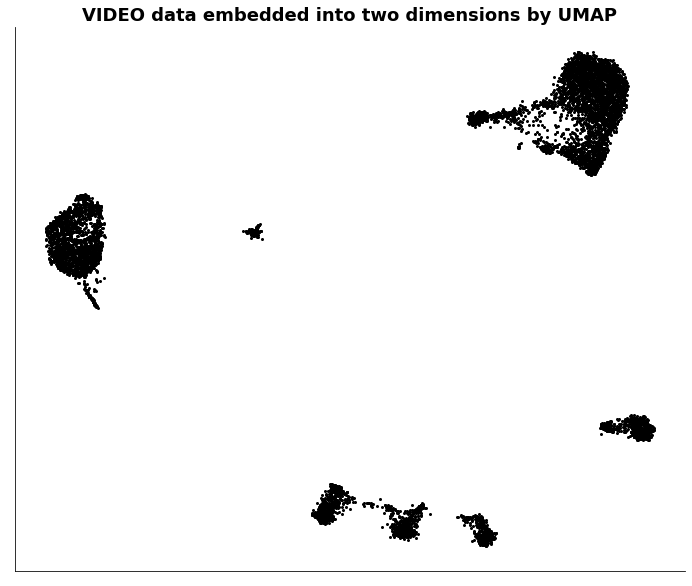

In [39]:
reducer   = umap.UMAP()
data      = latent_repVIDEO   ## stores posterior samples (10000x32 datapoints)
embedding = reducer.fit_transform(data)
fig, ax   = plt.subplots(1,figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], cmap="Spectral", s=4)
plt.setp(ax, xticks=[], yticks=[])
# cbar      = plt.colorbar(boundaries=np.arange(11)-0.5)
# cbar.set_ticks(np.arange(10))
# cbar.set_ticklabels(np.arange(10))
plt.title("VIDEO data embedded into two dimensions by UMAP", fontsize=18)
ax.set_facecolor('white')
plt.show()   

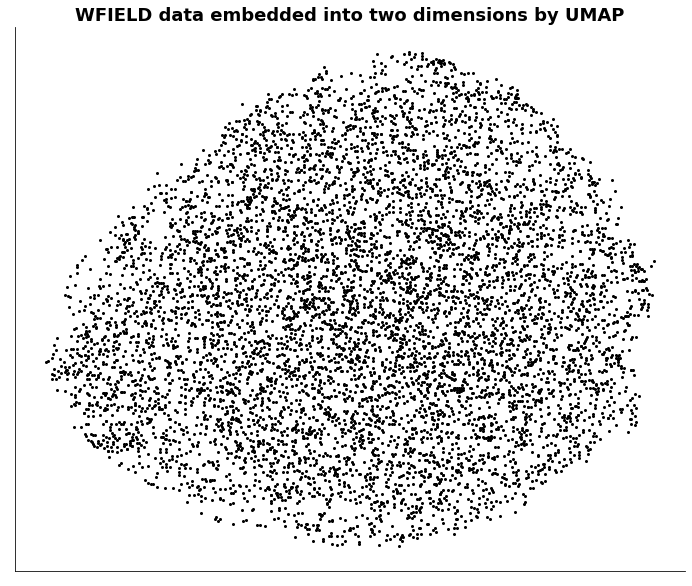

In [40]:
reducer   = umap.UMAP()
data      = latent_repWFIELD   ## stores posterior samples (10000x32 datapoints)
#color     = label_mnist       ## stores corresponding labels (10000, labels)
embedding = reducer.fit_transform(data)
fig, ax   = plt.subplots(1,figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], cmap="Spectral", s=4)
plt.setp(ax, xticks=[], yticks=[])
# cbar      = plt.colorbar(boundaries=np.arange(11)-0.5)
# cbar.set_ticks(np.arange(10))
# cbar.set_ticklabels(np.arange(10))
plt.title("WFIELD data embedded into two dimensions by UMAP", fontsize=18)
ax.set_facecolor('white')
plt.show()   

In [87]:
np.shape(data)

(90, 16)

In [41]:
state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()}
torch.save(state, PATH)